In [19]:
API_KEY = "005a68adc5b1790d133aa2aeab176807"  # Replace with the actual key
CITY = "Delhi"
BASE_URL = f"http://api.openweathermap.org/data/2.5/weather?q={CITY}&appid={API_KEY}"

def get_weather_data():
    try:
        response = requests.get(BASE_URL)
        response.raise_for_status()  # Raises HTTPError for bad responses (4xx, 5xx)
        data = response.json()
        if 'main' not in data or 'weather' not in data:
            raise WeatherAPIException("Invalid data format received from API.")
        return data
    except requests.exceptions.HTTPError as http_err:
        raise WeatherAPIException(f"HTTP error occurred: {http_err}")
    except Exception as err:
        raise WeatherAPIException(f"An error occurred: {err}")

# Test the API call after adding the correct API key
try:
    weather_data = get_weather_data()
    print(weather_data)  # Success
except WeatherAPIException as e:
    print(f"Error: {e}")


{'coord': {'lon': 77.2167, 'lat': 28.6667}, 'weather': [{'id': 721, 'main': 'Haze', 'description': 'haze', 'icon': '50n'}], 'base': 'stations', 'main': {'temp': 304.2, 'feels_like': 304.92, 'temp_min': 304.2, 'temp_max': 304.2, 'pressure': 1009, 'humidity': 45, 'sea_level': 1009, 'grnd_level': 984}, 'visibility': 3200, 'wind': {'speed': 2.06, 'deg': 30}, 'clouds': {'all': 0}, 'dt': 1729513125, 'sys': {'type': 1, 'id': 9165, 'country': 'IN', 'sunrise': 1729472135, 'sunset': 1729512934}, 'timezone': 19800, 'id': 1273294, 'name': 'Delhi', 'cod': 200}


In [20]:
# Define default threshold settings
default_thresholds = {
    "temperature": {"min": -50, "max": 50},  # Celsius
    "humidity": {"min": 0, "max": 100}  # Percent
}

class InvalidThresholdException(Exception):
    pass

def validate_thresholds(thresholds):
    # Ensure thresholds have valid ranges
    for key, threshold in thresholds.items():
        if threshold["min"] >= threshold["max"]:
            raise InvalidThresholdException(f"Invalid threshold range for {key}: min >= max.")
        if not isinstance(threshold["min"], (int, float)) or not isinstance(threshold["max"], (int, float)):
            raise InvalidThresholdException(f"Thresholds for {key} must be numbers.")
    return True

# Test threshold validation
try:
    user_thresholds = {
        "temperature": {"min": -40, "max": 40},  # Valid
        "humidity": {"min": 10, "max": 90}  # Valid
    }
    validate_thresholds(user_thresholds)
    print("Thresholds validated successfully.")
except InvalidThresholdException as e:
    print(f"Error: {e}")


Thresholds validated successfully.


In [21]:
# Simulate retrieved weather data (from OpenWeatherMap)
def get_sample_weather_data():
    return {
        "main": {
            "temp": 310.15,  # in Kelvin
            "humidity": 85
        },
        "weather": [{"main": "Clear"}],
        "dt": 1625158000  # Unix timestamp
    }

def kelvin_to_celsius(temp_kelvin):
    return temp_kelvin - 273.15

def check_alerts(weather_data, thresholds):
    temp_celsius = kelvin_to_celsius(weather_data["main"]["temp"])
    humidity = weather_data["main"]["humidity"]
    
    # Check temperature alert
    if temp_celsius > thresholds["temperature"]["max"]:
        print(f"Alert: Temperature {temp_celsius:.2f}°C exceeds {thresholds['temperature']['max']}°C")
    elif temp_celsius < thresholds["temperature"]["min"]:
        print(f"Alert: Temperature {temp_celsius:.2f}°C below {thresholds['temperature']['min']}°C")
    
    # Check humidity alert
    if humidity > thresholds["humidity"]["max"]:
        print(f"Alert: Humidity {humidity}% exceeds {thresholds['humidity']['max']}%")
    elif humidity < thresholds["humidity"]["min"]:
        print(f"Alert: Humidity {humidity}% below {thresholds['humidity']['min']}%")

# Test the alert system with sample weather data
sample_data = get_sample_weather_data()
check_alerts(sample_data, user_thresholds)


In [22]:
from datetime import datetime

weather_updates = []

def process_weather_update():
    data = get_sample_weather_data()
    temp_celsius = kelvin_to_celsius(data["main"]["temp"])
    humidity = data["main"]["humidity"]
    weather_condition = data["weather"][0]["main"]
    timestamp = data["dt"]
    
    # Convert timestamp to date for daily rollups
    date_str = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d')
    
    weather_updates.append({
        "date": date_str,
        "temp": temp_celsius,
        "humidity": humidity,
        "condition": weather_condition,
        "timestamp": timestamp
    })
    return weather_updates[-1]

# Simulate fetching weather data and generating daily summaries
for i in range(3):  # Simulate 3 updates
    update = process_weather_update()
    print(f"Update {i + 1}: {update}")

# Daily rollups (averages, max/min temperatures)
def calculate_daily_summary():
    daily_summary = {}
    
    for update in weather_updates:
        date = update["date"]
        if date not in daily_summary:
            daily_summary[date] = {"temps": [], "humidities": [], "conditions": []}
        
        daily_summary[date]["temps"].append(update["temp"])
        daily_summary[date]["humidities"].append(update["humidity"])
        daily_summary[date]["conditions"].append(update["condition"])
    
    for date, summary in daily_summary.items():
        avg_temp = sum(summary["temps"]) / len(summary["temps"])
        max_temp = max(summary["temps"])
        min_temp = min(summary["temps"])
        dominant_condition = max(set(summary["conditions"]), key=summary["conditions"].count)  # Most frequent condition
        
        print(f"\nSummary for {date}:")
        print(f"Average Temperature: {avg_temp:.2f}°C")
        print(f"Max Temperature: {max_temp:.2f}°C")
        print(f"Min Temperature: {min_temp:.2f}°C")
        print(f"Dominant Condition: {dominant_condition}")

# Calculate the daily summary
calculate_daily_summary()


Update 1: {'date': '2021-07-01', 'temp': 37.0, 'humidity': 85, 'condition': 'Clear', 'timestamp': 1625158000}
Update 2: {'date': '2021-07-01', 'temp': 37.0, 'humidity': 85, 'condition': 'Clear', 'timestamp': 1625158000}
Update 3: {'date': '2021-07-01', 'temp': 37.0, 'humidity': 85, 'condition': 'Clear', 'timestamp': 1625158000}

Summary for 2021-07-01:
Average Temperature: 37.00°C
Max Temperature: 37.00°C
Min Temperature: 37.00°C
Dominant Condition: Clear


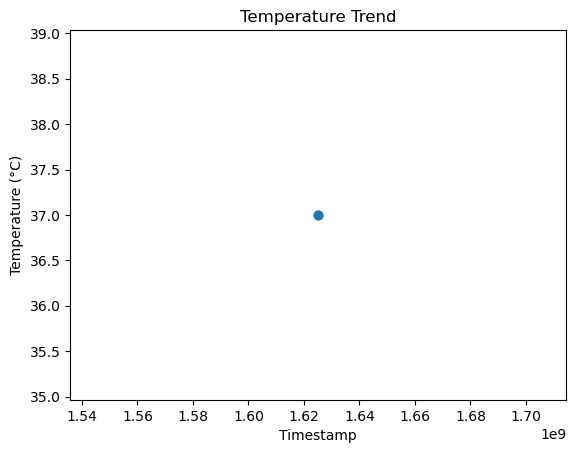

In [23]:
import matplotlib.pyplot as plt

def plot_temperature_trend():
    timestamps = [update['timestamp'] for update in weather_updates]
    temperatures = [update['temp'] for update in weather_updates]
    
    plt.plot(timestamps, temperatures, marker='o')
    plt.title('Temperature Trend')
    plt.xlabel('Timestamp')
    plt.ylabel('Temperature (°C)')
    plt.show()

# Call the function to visualize the data
plot_temperature_trend()


In [24]:
#BONUS

In [25]:
# Simulate weather data including humidity and wind speed
def get_extended_sample_weather_data():
    return {
        "main": {
            "temp": 303.15,  # Kelvin
            "humidity": 70,  # Percent
            "pressure": 1012  # hPa (hectopascal)
        },
        "wind": {
            "speed": 5.5  # Wind speed in meters/second
        },
        "weather": [{"main": "Clear"}],
        "dt": 1625158000  # Unix timestamp
    }

# Process the extended weather update
def process_extended_weather_update():
    data = get_extended_sample_weather_data()
    temp_celsius = kelvin_to_celsius(data["main"]["temp"])
    humidity = data["main"]["humidity"]
    wind_speed = data["wind"]["speed"]
    weather_condition = data["weather"][0]["main"]
    timestamp = data["dt"]
    
    # Convert timestamp to date for daily rollups
    date_str = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d')
    
    weather_updates.append({
        "date": date_str,
        "temp": temp_celsius,
        "humidity": humidity,
        "wind_speed": wind_speed,  # New parameter
        "condition": weather_condition,
        "timestamp": timestamp
    })
    return weather_updates[-1]

# Simulate fetching weather data and generating daily summaries
for i in range(3):  # Simulate 3 updates
    update = process_extended_weather_update()
    print(f"Update {i + 1}: {update}")


Update 1: {'date': '2021-07-01', 'temp': 30.0, 'humidity': 70, 'wind_speed': 5.5, 'condition': 'Clear', 'timestamp': 1625158000}
Update 2: {'date': '2021-07-01', 'temp': 30.0, 'humidity': 70, 'wind_speed': 5.5, 'condition': 'Clear', 'timestamp': 1625158000}
Update 3: {'date': '2021-07-01', 'temp': 30.0, 'humidity': 70, 'wind_speed': 5.5, 'condition': 'Clear', 'timestamp': 1625158000}


In [26]:
# Updated daily rollups to include additional weather parameters with error handling
def calculate_extended_daily_summary():
    daily_summary = {}
    
    for update in weather_updates:
        date = update["date"]
        if date not in daily_summary:
            daily_summary[date] = {"temps": [], "humidities": [], "wind_speeds": [], "conditions": []}
        
        daily_summary[date]["temps"].append(update["temp"])
        daily_summary[date]["humidities"].append(update["humidity"])
        
        # Check if wind_speed exists before appending
        if "wind_speed" in update:
            daily_summary[date]["wind_speeds"].append(update["wind_speed"])
        else:
            daily_summary[date]["wind_speeds"].append(None)  # or set a default value like 0
        
        daily_summary[date]["conditions"].append(update["condition"])
    
    for date, summary in daily_summary.items():
        avg_temp = sum(summary["temps"]) / len(summary["temps"])
        max_temp = max(summary["temps"])
        min_temp = min(summary["temps"])
        avg_humidity = sum(summary["humidities"]) / len(summary["humidities"])
        
        # Handle wind_speed averages only if data exists
        if summary["wind_speeds"] and None not in summary["wind_speeds"]:
            avg_wind_speed = sum(summary["wind_speeds"]) / len(summary["wind_speeds"])
        else:
            avg_wind_speed = "No data"
        
        dominant_condition = max(set(summary["conditions"]), key=summary["conditions"].count)
        
        print(f"\nSummary for {date}:")
        print(f"Average Temperature: {avg_temp:.2f}°C")
        print(f"Max Temperature: {max_temp:.2f}°C")
        print(f"Min Temperature: {min_temp:.2f}°C")
        print(f"Average Humidity: {avg_humidity:.2f}%")
        print(f"Average Wind Speed: {avg_wind_speed} m/s")  # Show 'No data' if no wind speed info
        print(f"Dominant Condition: {dominant_condition}")

# Call the function to calculate and print the summary
calculate_extended_daily_summary()



Summary for 2021-07-01:
Average Temperature: 33.50°C
Max Temperature: 37.00°C
Min Temperature: 30.00°C
Average Humidity: 77.50%
Average Wind Speed: No data m/s
Dominant Condition: Clear


In [27]:
#BONUS 2
import requests

def get_weather_forecast():
    # API request for 5-day forecast (with 3-hour intervals)
    forecast_url = f"http://api.openweathermap.org/data/2.5/forecast?q={CITY}&appid={API_KEY}"
    
    try:
        response = requests.get(forecast_url)
        response.raise_for_status()  # Raise error for bad responses
        forecast_data = response.json()
        return forecast_data
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except Exception as err:
        print(f"Error occurred: {err}")

# Retrieve and print forecast data
forecast_data = get_weather_forecast()
print(forecast_data)  # Check the structure of forecast data


{'cod': '200', 'message': 0, 'cnt': 40, 'list': [{'dt': 1729522800, 'main': {'temp': 304.23, 'feels_like': 304.17, 'temp_min': 304.23, 'temp_max': 304.3, 'pressure': 1010, 'sea_level': 1010, 'grnd_level': 986, 'humidity': 40, 'temp_kf': -0.07}, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'clouds': {'all': 0}, 'wind': {'speed': 1.98, 'deg': 89, 'gust': 2.66}, 'visibility': 10000, 'pop': 0, 'sys': {'pod': 'n'}, 'dt_txt': '2024-10-21 15:00:00'}, {'dt': 1729533600, 'main': {'temp': 303.21, 'feels_like': 302.58, 'temp_min': 302.72, 'temp_max': 303.21, 'pressure': 1010, 'sea_level': 1010, 'grnd_level': 986, 'humidity': 37, 'temp_kf': 0.49}, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'clouds': {'all': 0}, 'wind': {'speed': 1.73, 'deg': 90, 'gust': 3.55}, 'visibility': 10000, 'pop': 0, 'sys': {'pod': 'n'}, 'dt_txt': '2024-10-21 18:00:00'}, {'dt': 1729544400, 'main': {'temp': 301.61, 'feels_like': 300.94, 'temp

In [28]:
# Process forecast data and generate summaries
def process_forecast_data(forecast_data):
    forecast_updates = []
    
    for entry in forecast_data["list"]:  # List of forecast entries (3-hour intervals)
        temp_celsius = kelvin_to_celsius(entry["main"]["temp"])
        humidity = entry["main"]["humidity"]
        wind_speed = entry["wind"]["speed"]
        weather_condition = entry["weather"][0]["main"]
        timestamp = entry["dt"]
        
        # Convert timestamp to date for daily forecast rollups
        date_str = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d')
        
        forecast_updates.append({
            "date": date_str,
            "temp": temp_celsius,
            "humidity": humidity,
            "wind_speed": wind_speed,
            "condition": weather_condition,
            "timestamp": timestamp
        })
    
    return forecast_updates

# Process forecast data
forecast_updates = process_forecast_data(forecast_data)

# Generate forecast summary (average forecasted temperature, humidity, etc.)
def calculate_forecast_summary(forecast_updates):
    daily_forecast_summary = {}
    
    for update in forecast_updates:
        date = update["date"]
        if date not in daily_forecast_summary:
            daily_forecast_summary[date] = {"temps": [], "humidities": [], "wind_speeds": [], "conditions": []}
        
        daily_forecast_summary[date]["temps"].append(update["temp"])
        daily_forecast_summary[date]["humidities"].append(update["humidity"])
        daily_forecast_summary[date]["wind_speeds"].append(update["wind_speed"])
        daily_forecast_summary[date]["conditions"].append(update["condition"])
    
    for date, summary in daily_forecast_summary.items():
        avg_temp = sum(summary["temps"]) / len(summary["temps"])
        avg_humidity = sum(summary["humidities"]) / len(summary["humidities"])
        avg_wind_speed = sum(summary["wind_speeds"]) / len(summary["wind_speeds"])
        dominant_condition = max(set(summary["conditions"]), key=summary["conditions"].count)
        
        print(f"\nForecast Summary for {date}:")
        print(f"Average Forecasted Temperature: {avg_temp:.2f}°C")
        print(f"Average Forecasted Humidity: {avg_humidity:.2f}%")
        print(f"Average Forecasted Wind Speed: {avg_wind_speed:.2f} m/s")
        print(f"Dominant Forecasted Condition: {dominant_condition}")

# Calculate forecast summary
calculate_forecast_summary(forecast_updates)



Forecast Summary for 2024-10-21:
Average Forecasted Temperature: 29.87°C
Average Forecasted Humidity: 37.67%
Average Forecasted Wind Speed: 1.63 m/s
Dominant Forecasted Condition: Clear

Forecast Summary for 2024-10-22:
Average Forecasted Temperature: 31.14°C
Average Forecasted Humidity: 26.00%
Average Forecasted Wind Speed: 1.29 m/s
Dominant Forecasted Condition: Clear

Forecast Summary for 2024-10-23:
Average Forecasted Temperature: 31.00°C
Average Forecasted Humidity: 22.50%
Average Forecasted Wind Speed: 2.08 m/s
Dominant Forecasted Condition: Clear

Forecast Summary for 2024-10-24:
Average Forecasted Temperature: 31.23°C
Average Forecasted Humidity: 19.75%
Average Forecasted Wind Speed: 1.95 m/s
Dominant Forecasted Condition: Clear

Forecast Summary for 2024-10-25:
Average Forecasted Temperature: 30.59°C
Average Forecasted Humidity: 24.62%
Average Forecasted Wind Speed: 1.55 m/s
Dominant Forecasted Condition: Clear

Forecast Summary for 2024-10-26:
Average Forecasted Temperature: